### Imports

In [3]:
from nltk.corpus import movie_reviews as reviews
from sklearn.datasets import fetch_20newsgroups
from gensim.models import KeyedVectors
from gensim.models import word2vec

import numpy as np
import pandas as pd
import re
import datetime
from operator import itemgetter
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt

import os
import time
import string
import dill
import pickle

from nltk import *
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
from nltk.stem.snowball import SnowballStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split as tts
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, SpatialDropout1D, Activation, Conv1D, MaxPooling1D, Input, concatenate
from keras.utils.np_utils import to_categorical

/anaconda3/envs/py36/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


### Data retrieving

In [5]:
data_essays = pd.read_csv('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Text/essays.csv', encoding = "ISO-8859-1")
data_essays['cEXT'] = np.where(data_essays['cEXT']=='y', 1, 0)
data_essays['cNEU'] = np.where(data_essays['cNEU']=='y', 1, 0)
data_essays['cAGR'] = np.where(data_essays['cAGR']=='y', 1, 0)
data_essays['cCON'] = np.where(data_essays['cCON']=='y', 1, 0)
data_essays['cOPN'] = np.where(data_essays['cOPN']=='y', 1, 0)
X_essays = data_essays['TEXT'].tolist()
y_essays = data_essays[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]
data_essays['text length'] = data_essays['TEXT'].apply(len)
labels = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

In [37]:
mairesse = pd.read_csv("mairesse.csv", header = -1).drop(0, axis = 1)

In [39]:
X_essays = pd.concat([data_essays['TEXT'], mairesse], axis=1, sort=False)

### Visualization

Text length distrbution for the different labels

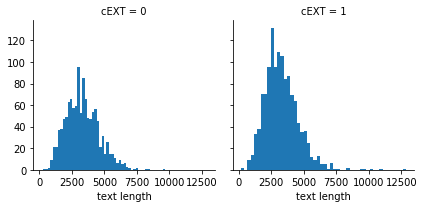

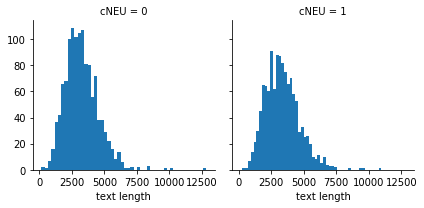

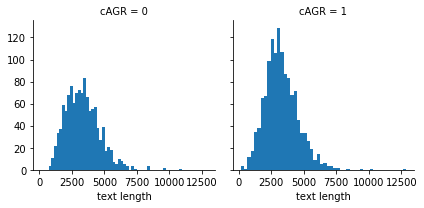

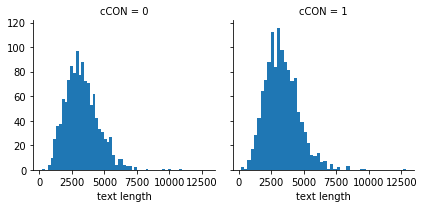

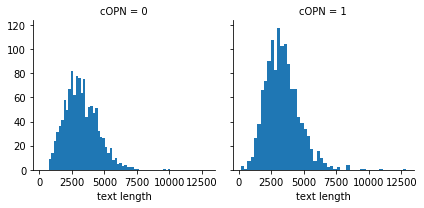

In [57]:
for label in labels :
    g = sns.FacetGrid(data=data_essays, col=label)
    g.map(plt.hist, 'text length', bins=50)

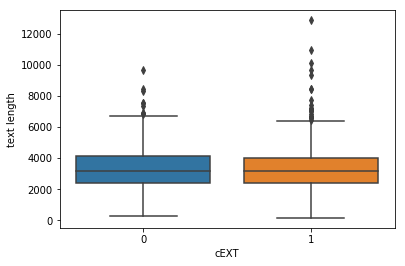

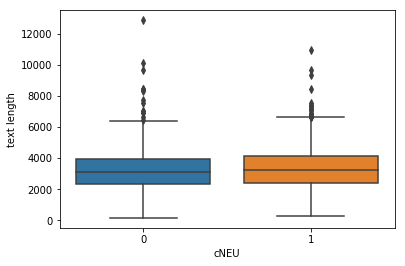

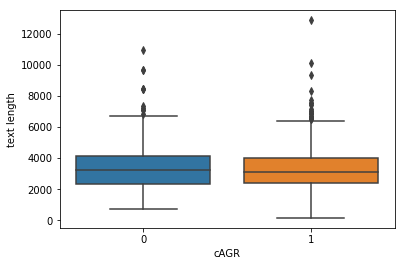

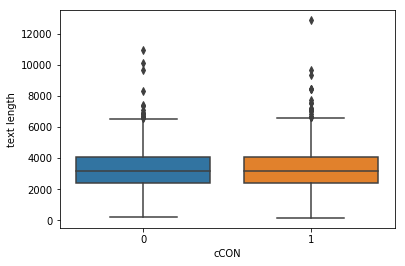

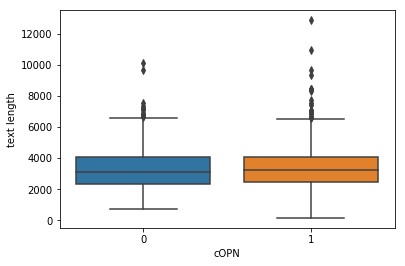

In [66]:
for i, label in enumerate(labels):
    plt.figure(i)
    sns.boxplot(x=label, y='text length', data=data_essays)

Most common words in the corpus

In [63]:
complete_corpus = ' '.join(X_essays)
words = tokenize.word_tokenize(complete_corpus)
fdist = FreqDist(words)
print(fdist.most_common(100))

[('I', 115468), ('.', 111178), ('to', 56263), (',', 47355), ('the', 38232), ('and', 36810), ('that', 29456), ('a', 28408), ('my', 26580), ('is', 25576), ('of', 22939), ('it', 22781), ("n't", 19996), ('in', 17828), ('do', 17448), ('have', 16166), ('me', 14588), ('so', 13099), ('but', 13060), ('this', 12054), ('be', 11724), ('for', 11520), ("'s", 11198), ('was', 10392), ('am', 10378), ('like', 10308), ('just', 10250), ('really', 10207), ('not', 10015), ("'m", 9973), ('on', 9015), ('about', 8941), ('with', 8708), ('think', 8061), ('are', 7602), ('what', 7517), ('all', 7475), ('at', 7469), ('because', 7144), ('i', 7047), ('know', 6959), ('get', 6875), ('he', 6605), ('now', 6154), ('would', 6077), ('you', 6013), ('if', 6001), ('time', 5966), ('out', 5923), ('they', 5905), ('up', 5743), ('or', 5733), ('going', 5621), ('go', 5576), ('she', 5556), ('?', 5539), ('want', 5483), ('will', 5420), ('can', 5276), ('!', 4959), ('as', 4939), ('people', 4898), ('her', 4879), ('when', 4867), ('we', 4836)

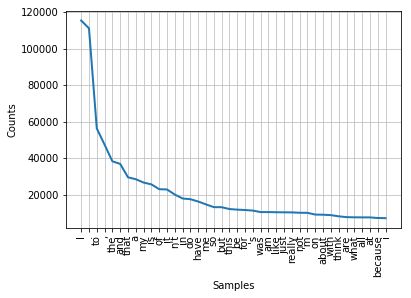

In [65]:
fdist.plot(40)

In [158]:
# Retrieve some info on the text data to chose RNN parameters
numWords = []
for text in X_essays:
        counter = len(text.split())
        numWords.append(counter)  

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 2467
The total number of words in the files is 1608813
The average number of words in the files is 652.1333603567085


In [159]:
prep = NLTKPreprocessor(X_essays, neural_network = True, stopwords=None, punct=None, lower=True, strip=True)
X_essays_preprocess = prep.transform(X_essays).tolist()
# Retrieve some info on the text data to chose embedding dimension
len_list = [np.count_nonzero(X_essays_preprocess[i]) for i in range(0,2450)]
print(np.mean(len_list))
print(np.std(len_list))
print(np.mean(len_list) + 2 * np.std(len_list))

168.24163265306123
68.28342181886924
304.8084762907997


### Complete Modeling

In [7]:
# Params
max_sentence_len = 300
max_features = 30000
embed_dim = 300
lstm_out = 196

# Training params


class MyRNNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rnn, neural_network):
        self.rnn = rnn
        self.neural_network = neural_network

    def fit(self, X, y):
        batch_size = 36
        num_epochs = 35
        batch_size = batch_size
        epochs = num_epochs
        if self.neural_network: 
            self.rnn.fit(X, y, epochs = epochs, batch_size=batch_size, verbose = 2)
            return self
        else :
            self.rnn.fit(X, y)
            return self

    def transform(self, X):
        if self.neural_network:
            self.pred = self.rnn.predict(X)
        else :
            self.pred = self.rnn.predict_proba(X)
        self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
        return self.classes
        
    

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})


def genericize_mentions(text):
    return re.sub(r'@[\w_-]+', 'thisisanatmention', text)


def reshape_a_feature_column(series):
    return np.reshape(np.asarray(series), (len(series), 1))


def pipelinize_feature(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            processed = [function(i) for i in list_or_series]
            processed = reshape_a_feature_column(processed)
            return processed
#         This is incredibly stupid and hacky, but we need it to do a grid search with activation/deactivation.
#         If a feature is deactivated, we're going to just return a column of zeroes.
#         Zeroes shouldn't affect the regression, but other values may.
#         If you really want brownie points, consider pulling out that feature column later in the pipeline.
        else:
            return reshape_a_feature_column(np.zeros(len(list_or_series)))

def get_text_length(text):
    return len(text)


def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper


def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

def multiclass_accuracy(predictions, true):
    score = []
    for j in range(0,5):
        count = 0
        for i in range(len(predictions)):
            if predictions[i][j] == true[i][j]:
                count += 1
        score.append(count/len(predictions))
    return score

def load_google_vec():
    return KeyedVectors.load_word2vec_format('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Text/GoogleNews-vectors-negative300.bin', binary=True)

def extract_words_external(X_corpus):
    X = ' '.join(X_corpus)
    lemmatized_tokens = []
    # Break the document into sentences
    for sent in sent_tokenize(X):
        # Break the sentence into part of speech tagged tokens
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # Apply preprocessing to the token
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If punctuation or stopword, ignore token and continue
            if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token) or len(token)<=1:
                continue

            # Lemmatize the token and yield
            lemma = lemmatize_external(token, tag)
            lemmatized_tokens.append(lemma)
            
    doc = ' '.join(lemmatized_tokens)
    return doc

def lemmatize_external(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)
    return WordNetLemmatizer().lemmatize(token, tag)

def prepare_embedding(max_features, max_sentence_len, X):
    word2vec = load_google_vec()
    tokenizer = Tokenizer(num_words=max_features)
    X_pad = extract_words_external(X)
    tokenizer.fit_on_texts(pd.Series(X_pad))
    X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))
    X_pad = pad_sequences(X_pad, maxlen = max_sentence_len, padding = 'post', truncating = 'post')
    train_word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(train_word_index))
    train_embedding_weights = np.zeros((len(train_word_index)+1, embed_dim))
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embed_dim)
    word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),pd.Series(list(train_word_index.keys())).apply(lambda x: train_embedding_weights[train_word_index[x]])))
    return train_embedding_weights, train_word_index, word_vector_dict

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transforms input data by using NLTK tokenization, lemmatization, and
    other normalization and filtering techniques.
    """

    def __init__(self, corpus, neural_network, stopwords=None, punct=None, lower=True, strip=True):
        """
        Instantiates the preprocessor, which make load corpora, models, or do
        other time-intenstive NLTK data loading.
        """
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = set(stopwords) if stopwords else set(sw.words('english'))
        self.punct      = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.neural_network = neural_network
        self.corpus = corpus

    def fit(self, X, y=None):
        """
        Fit simply returns self, no other information is needed.
        """
        return self

    def inverse_transform(self, X):
        """
        No inverse transformation
        """
        return X

    def transform(self, X):
        """
        Actually runs the preprocessing on each document.
        """
        if self.neural_network == True:
            output= np.array([(self.tokenize_nn(doc)) for doc in X])
        else :
            output = [self.tokenize(doc) for doc in X]
        return output

        
    def tokenize_nn(self, document, max_features = max_features):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation (breaking into sentences), then word/punctuation
        tokenization, and finally part of speech tagging. It uses the part of
        speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        lemmatized_tokens = []
        # Clean the text
        document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
        document = re.sub(r"what's", "what is ", document)
        document = re.sub(r"\'s", " ", document)
        document = re.sub(r"\'ve", " have ", document)
        document = re.sub(r"can't", "cannot ", document)
        document = re.sub(r"n't", " not ", document)
        document = re.sub(r"i'm", "i am ", document)
        document = re.sub(r"\'re", " are ", document)
        document = re.sub(r"\'d", " would ", document)
        document = re.sub(r"\'ll", " will ", document)
        document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
        return tokenized_document

    def tokenize(self, document, max_features = 30000):
        lemmatized_tokens = []
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token) or len(token)<=1:
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
        return tokenized_document


    def vectorize(self, doc):
        save_path = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/padding.pickle"
        with open(save_path, 'rb') as f:
            tokenizer = pickle.load(f)
        doc_pad = tokenizer.texts_to_sequences(doc)
        doc_pad = pad_sequences(doc_pad, padding = 'pre', truncating = 'pre', maxlen = max_sentence_len)
        return np.squeeze(doc_pad)


    def lemmatize(self, token, tag):
        """
        Converts the Penn Treebank tag to a WordNet POS tag, then uses that
        tag to perform much more accurate WordNet lemmatization.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
    
    
@timeit
def build_and_evaluate(X, y, neural_network, y_format, multiclass, classifier=SGDClassifier, model_name=None, verbose=True):
    """
    Builds a classifer for the given list of documents and targets in two
    stages: the first does a train/test split and prints a classifier report,
    the second rebuilds the model on the entire corpus and returns it for
    operationalization.
    X: a list or iterable of raw strings, each representing a document.
    y: a list or iterable of labels, which will be label encoded.
    Can specify the classifier to build with: if a class is specified then
    this will build the model with the Scikit-Learn defaults, if an instance
    is given, then it will be used directly in the build pipeline.
    If model_name is given, this function will write the model as a pickle.
    If verbose, this function will print out information to the command line.
    """

    @timeit
    def build(classifier, X, y, embedding_dict, neural_network, corpus):
        """
        Inner build function that builds a single model.
        """
        if neural_network:
            model = Pipeline([
                    ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
                    ('classifier', classifier)
                    ])
        else:
            '''
            classifier = OneVsRestClassifier(classifier(), n_jobs=-1)
            model = Pipeline([
                    ('features', FeatureUnion([
                    ('vectorizer', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
                    ('text_length', pipelinize_feature(get_text_length, active=True))
                    ])),
                    ('classifier', classifier)
                    ])
            '''
            model = Pipeline([
                    ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
                    ("wordVectz",TfidfEmbeddingVectorizer(embedding_dict)),
                    ('clf', classifier)
                    ])
                
#('genericize_mentions', pipelinize(genericize_mentions)),
        return model.fit(X, y)

    # Label encode the targets
    if y_format:
        y_trans = y
    else:
        if neural_network:
            y_trans= pd.get_dummies(y).values
        else:
            labels = LabelEncoder()
            y_trans = labels.fit_transform(y)
    
    # Prepare the embedding 
    train_embedding_weights, train_word_index, wv_dict = prepare_embedding(max_features, max_sentence_len, X)

    # Begin evaluation
    if verbose: print("Building for evaluation")
    indices = range(len(y))
    X_train, X_test, y_train, y_test, indices_train, indices_test = tts(X, y_trans, indices, test_size=0.2)
    
    if classifier == "RNN":
        Input_words = Input(shape=(300,), name='input1')
        x = Embedding(len(train_word_index)+1,embed_dim,weights=[train_embedding_weights],input_length= max_sentence_len,trainable=True)(Input_words)
        #classifier.add(Embedding(30000, 300,input_length = 350))
        x = Conv1D(filters=50, kernel_size=8, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = SpatialDropout1D(0.2)(x)
        x = BatchNormalization()(x)
        x = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)(x)
        out = Dense(5,activation='softmax')(x)
        classifier = Model(inputs=Input_words, outputs=[out])
        classifier.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        print(classifier.summary())

    
    if neural_network:
        model, secs = build(MyRNNTransformer(classifier, neural_network), X_train, y_train, wv_dict, neural_network = neural_network, corpus = X)
    else:
        model, secs = build(classifier, X_train, y_train, wv_dict, neural_network = neural_network, corpus = X)
    
    if verbose: print("Evaluation model fit in {:0.3f} seconds".format(secs))
    if verbose: print("Classification Report:\n")

    #weights_model = model.layers[0].get_weights()
    
    y_pred = model.transform(X_test)
    if multiclass:
        print(multiclass_accuracy(y_test.values.tolist(), y_pred))
    else:
        labels = LabelEncoder()
        y = labels.fit_transform(y_test)
        print(clsr(y_test, y_pred, target_names=labels.classes_.astype(str)))
    

    if verbose: print("Building complete model and saving ...")
    if neural_network:
        model, secs = build(MyRNNTransformer(classifier, neural_network), X, y_trans, wv_dict, neural_network = neural_network, corpus = X)
    else:
        model, secs = build(classifier, X, y_trans, wv_dict, neural_network = neural_network, corpus = X)
        
        #model.labels_ = labels

    if verbose: print("Complete model fit in {:0.3f} seconds".format(secs))
    parameters = model.get_params(deep = True)
    
    if model_name:
        outpath = '/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/'
        if neural_network:
            classifier.save_weights(outpath + model_name + '.h5')
            with open(outpath + model_name + '.json', 'w') as json_file:
                json_file.write(classifier.to_json())
        else:
            with open(outpath + model_name , 'wb') as f:
                dill.dump(model, f)

        print("Model written out to {}".format(model_name))
        
    return model

def load_and_predict(X,y, model_name, corpus, neural_network, multiclass):
    @timeit
    def build(classifier, neural_network, corpus):
        """
        Inner build function that builds a single model.
        """
        '''
        if isinstance(classifier, type):
            classifier = classifier()
        '''    
        if neural_network:
            model = Pipeline([
            ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
            ('classifier', classifier())
            ])
        else : 
            model = Pipeline([
            ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
            ('features', FeatureUnion([
            ('vectorizer', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
            ('text_length', pipelinize_feature(get_text_length, active=True))
            ])),
            ('classifier', classifier)
            ])
#('genericize_mentions', pipelinize(genericize_mentions)),
        return model

    if neural_network:
        save_path = '/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/'
        json_file = open(save_path + model_name + '.json', 'r')
        classifier = model_from_json(json_file.read())
        classifier.load_weights(save_path + model_name + '.h5')
        classifier.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        json_file.close()
        model, secs = build(MyRNNTransformer(classifier, neural_network), neural_network, corpus)
        y_pred = model.transform(X)
    else :
        save_path = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/"
        with open(save_path + model_name, 'rb') as f:
            model = dill.load(f)
        y_pred = model.predict(X)
    if multiclass:
        print(multiclass_accuracy(y.values.tolist(), y_pred))
    else:
        labels = LabelEncoder()
        y = labels.fit_transform(y)
        print(clsr(y, y_pred, target_names=labels.classes_.astype(str)))

    return y_pred



def show_most_informative_features(model, text=None, n=20):
    """
    Accepts a Pipeline with a classifer and a TfidfVectorizer and computes
    the n most informative features of the model. If text is given, then will
    compute the most informative features for classifying that text.
    Note that this function will only work on linear models with coefs_
    """
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['features'].transformer_list[0][1]
    classifier = model.named_steps['classifier']

    # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {} model.".format(
                classifier.__class__.__name__
            )
        )

    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=True
    )

    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append("Classified as: {}".format(model.predict([text])))
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(cp, fnp, cn, fnn)
        )

    return "\n".join(output)

In [36]:
prediction = load_and_predict(X_essays[950:1020],y_essays[950:1020],  'SVM_essays_1', X_essays[950:1020], neural_network=False, multiclass = True)

0.4142857142857143


In [6]:
mod = build_and_evaluate(X_essays, y_essays,y_format = True, multiclass = True, neural_network = True, classifier='RNN', model_name='RNN_essays_full_mairesse', verbose=True)

Found 25278 unique tokens.
Building for evaluation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          7583700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 50)           120050    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 50)           0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 50)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 50)           200       
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               193648    
_________________________________________________________________
dense_1 (Dense)          

AttributeError: 'str' object has no attribute 'fit'

In [43]:
mod = build_and_evaluate(X_essays, y_essays,y_format = True, multiclass = True, neural_network = False, model_name='SVM_essays', verbose=True)

KeyboardInterrupt: 

### RNN Tensorflow manual

In [490]:
def tokenize(document):
    """
    Returns a normalized, lemmatized list of tokens from a document by
    applying segmentation (breaking into sentences), then word/punctuation
    tokenization, and finally part of speech tagging. It uses the part of
    speech tags to look up the lemma in WordNet, and returns the lowercase
    version of all the words, removing stopwords and punctuation.
    """
    lemmatized_tokens = []
    # Break the document into sentences
    for sent in sent_tokenize(document):
        # Break the sentence into part of speech tagged tokens
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # Apply preprocessing to the token
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If punctuation or stopword, ignore token and continue
            if token in sw.words('english') or all(char in set(string.punctuation) for char in token) or len(token)<=1:
                continue

            # Lemmatize the token and yield
            lemma = lemmatize(token, tag)
            lemmatized_tokens.append(lemma)
    return ' '.join(lemmatized_tokens)

def lemmatize(token, tag):
    """
    Converts the Penn Treebank tag to a WordNet POS tag, then uses that
    tag to perform much more accurate WordNet lemmatization.
    """
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return WordNetLemmatizer().lemmatize(token, tag)


In [4]:
# Load the input data
wordsList = np.load('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/training_data/wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/training_data/wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [5]:
# Retrieve some info on the text data to chose RNN parameters
numWords = []
for text in X:
        counter = len(text.split())
        numWords.append(counter)       

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 2000
The total number of words in the files is 1492681
The average number of words in the files is 746.3405


In [99]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())


# Build the integerized matrix of the texts
maxSeqLength = 750
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for text in X:
        indexCounter = 0
        cleanedLine = cleanSentences(text)
        lemmatizedLine = tokenize(cleanedLine)
        split = lemmatizedLine.split()
        for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        fileCounter = fileCounter + 1 

np.save('idsMatrix_movie_revies', ids)

In [27]:
# If the ids file has already been created
maxSeqLength = 750
ids = np.load('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/idsMatrix_movie_revies.npy')

In [11]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,899)
            labels.append([1,0])
        else:
            num = randint(1100,1999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(899,1100)
        if (num <= 999):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

In [18]:
numDimensions = 50
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 1000

tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [20]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# For tensorboard visualization
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

/anaconda3/envs/py36/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})

#Write summary to Tensorboard
if (i % 2 == 0):
    summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
    writer.add_summary(summary, i)
#Save the network every 10,000 training iterations
#if (i % 10000 == 0 and i != 0):
save_path = saver.save(sess, "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2/pretrained_lstm.ckpt", global_step=1000)
print("saved to %s" % save_path)
writer.close()

saved to /Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2/pretrained_lstm.ckpt-1000


In [22]:
# To test the ongoin model on a test set
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2'))

iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

INFO:tensorflow:Restoring parameters from /Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2/pretrained_lstm.ckpt-1000


/anaconda3/envs/py36/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Accuracy for this batch: 62.5
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 29.16666567325592
Accuracy for this batch: 75.0
Accuracy for this batch: 79.16666865348816
Accuracy for this batch: 29.16666567325592
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 45.83333432674408


### T_SNE Visualization

In [98]:
def tsne_plot(Vectors,List, n_elements):
    import random
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    l_bound = 0
    u_bound = len(List)
    step = int(len(List)/n_elements)

    #for index in range(l_bound,u_bound, step):
    for index in random.sample(range(l_bound,u_bound), n_elements):
        tokens.append(Vectors[index])
        labels.append(List[index])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    xx = []
    yy = []
    for value in new_values:
        xx.append(value[0])
        yy.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(xx)):
        plt.scatter(xx[i],yy[i])
        plt.annotate(labels[i],
                     xy=(xx[i], yy[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

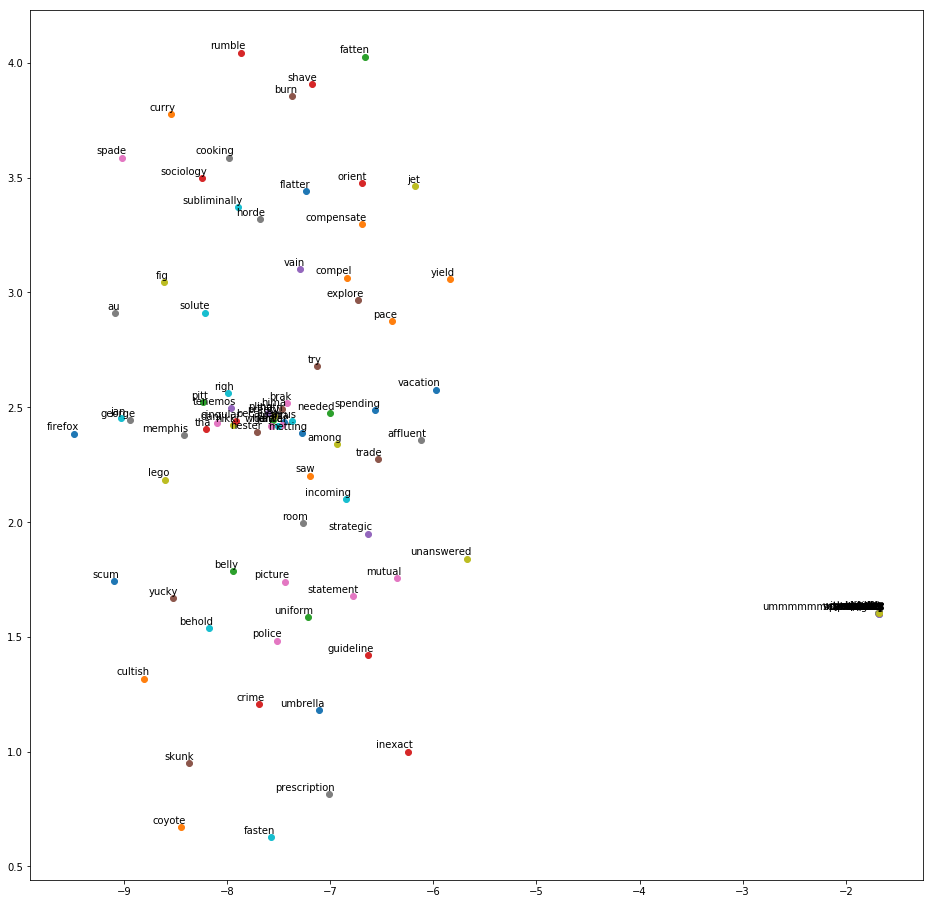

In [97]:
weights, index, dic = prepare_embedding(30000, 800, X_essays)
tsne_plot(list(dic.values()),list(dic.keys()), 100)